## Data preprocessing and logistic regression for binary classification tasks

## Libs

In [0]:
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline

## Dataset

This dataset includes 249 features (or predictors). Participants should use these variables to predict the target variable (or outcome), "Grant Status". A grant status of 1 represents a successful grant application, while a grant status of 0 represents an unsuccessful application. 

The training dataset, which participants use to build their models, is unimelb_training.csv. It contains 8,707 grant applications from late 2005 to 2008. The test dataset, unimelb_test.csv, contains 2,176 grant applications from 2009 to mid 2010. The grant status variable is withheld from the test dataset.

https://www.kaggle.com/c/unimelb.

In [0]:
data = pd.read_csv('https://raw.githubusercontent.com/OzmundSedler/100-Days-Of-ML-Code/master/week%201/datasets/data.csv')
data.shape

(6000, 39)

In [0]:
data.head()

,Grant.Status,Sponsor.Code,Grant.Category.Code,Contract.Value.Band...see.note.A,RFCD.Code.1,RFCD.Percentage.1,RFCD.Code.2,RFCD.Percentage.2,RFCD.Code.3,RFCD.Percentage.3,RFCD.Code.4,RFCD.Percentage.4,RFCD.Code.5,RFCD.Percentage.5,SEO.Code.1,SEO.Percentage.1,SEO.Code.2,SEO.Percentage.2,SEO.Code.3,SEO.Percentage.3,SEO.Code.4,SEO.Percentage.4,SEO.Code.5,SEO.Percentage.5,Person.ID.1,Role.1,Year.of.Birth.1,Country.of.Birth.1,Home.Language.1,Dept.No..1,Faculty.No..1,With.PHD.1,No..of.Years.in.Uni.at.Time.of.Grant.1,Number.of.Successful.Grant.1,Number.of.Unsuccessful.Grant.1,A..1,A.1,B.1,C.1
0,1,21A,50A,A,230202.0,50.0,230203.0,30.0,230204.0,20.0,0.0,0.0,0.0,0.0,780101.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,493297.0,CHIEF_INVESTIGATOR,1965.0,Australia,NaN,3098.0,31.0,Yes,>=0 to 5,2.0,0.0,0.0,4.0,2.0,0.0
1,1,4D,10A,D,320801.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,730112.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,330592.0,CHIEF_INVESTIGATOR,1965.0,Australia,NaN,2553.0,25.0,Yes,>=0 to 5,3.0,1.0,0.0,2.0,0.0,0.0
2,0,NaN,NaN,NaN,320602.0,50.0,321004.0,30.0,321015.0,20.0,0.0,0.0,0.0,0.0,730203.0,60.0,730105.0,20.0,730108.0,20.0,0.0,0.0,0.0,0.0,66887.0,CHIEF_INVESTIGATOR,1955.0,Australia,NaN,2813.0,25.0,NaN,Less than 0,1.0,5.0,0.0,7.0,2.0,0.0
3,0,51C,20C,A,291503.0,60.0,321402.0,40.0,0.0,0.0,0.0,0.0,0.0,0.0,730114.0,60.0,671401.0,40.0,0.0,0.0,0.0,0.0,0.0,0.0,63812.0,CHIEF_INVESTIGATOR,1950.0,Great Britain,NaN,2553.0,25.0,NaN,more than 15,2.0,1.0,5.0,6.0,9.0,1.0
4,0,24D,30B,NaN,380107.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,730108.0,50.0,730306.0,50.0,0.0,0.0,0.0,0.0,0.0,0.0,13687.0,CHIEF_INVESTIGATOR,1970.0,Australia,NaN,2923.0,25.0,NaN,Less than 0,0.0,2.0,0.0,0.0,0.0,0.0


In [0]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 39 columns):
Grant.Status                              6000 non-null int64
Sponsor.Code                              5387 non-null object
Grant.Category.Code                       5387 non-null object
Contract.Value.Band...see.note.A          3539 non-null object
RFCD.Code.1                               5583 non-null float64
RFCD.Percentage.1                         5583 non-null float64
RFCD.Code.2                               5583 non-null float64
RFCD.Percentage.2                         5583 non-null float64
RFCD.Code.3                               5583 non-null float64
RFCD.Percentage.3                         5583 non-null float64
RFCD.Code.4                               5583 non-null float64
RFCD.Percentage.4                         5583 non-null float64
RFCD.Code.5                               5583 non-null float64
RFCD.Percentage.5                         5583 non-null float64
SE

Let's set our target variable Grant.Status as y.

X is our training data, y - answers on it.

In [0]:
X = data.drop('Grant.Status', 1)
y = data['Grant.Status']

## Data Preprocessing

We need to be sure, that:

*   All X is numerical (if there are categorical columns we need to encode them)
*   There are no missing values in data


In [0]:
data.head()

,Grant.Status,Sponsor.Code,Grant.Category.Code,Contract.Value.Band...see.note.A,RFCD.Code.1,RFCD.Percentage.1,RFCD.Code.2,RFCD.Percentage.2,RFCD.Code.3,RFCD.Percentage.3,RFCD.Code.4,RFCD.Percentage.4,RFCD.Code.5,RFCD.Percentage.5,SEO.Code.1,SEO.Percentage.1,SEO.Code.2,SEO.Percentage.2,SEO.Code.3,SEO.Percentage.3,SEO.Code.4,SEO.Percentage.4,SEO.Code.5,SEO.Percentage.5,Person.ID.1,Role.1,Year.of.Birth.1,Country.of.Birth.1,Home.Language.1,Dept.No..1,Faculty.No..1,With.PHD.1,No..of.Years.in.Uni.at.Time.of.Grant.1,Number.of.Successful.Grant.1,Number.of.Unsuccessful.Grant.1,A..1,A.1,B.1,C.1
0,1,21A,50A,A,230202.0,50.0,230203.0,30.0,230204.0,20.0,0.0,0.0,0.0,0.0,780101.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,493297.0,CHIEF_INVESTIGATOR,1965.0,Australia,NaN,3098.0,31.0,Yes,>=0 to 5,2.0,0.0,0.0,4.0,2.0,0.0
1,1,4D,10A,D,320801.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,730112.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,330592.0,CHIEF_INVESTIGATOR,1965.0,Australia,NaN,2553.0,25.0,Yes,>=0 to 5,3.0,1.0,0.0,2.0,0.0,0.0
2,0,NaN,NaN,NaN,320602.0,50.0,321004.0,30.0,321015.0,20.0,0.0,0.0,0.0,0.0,730203.0,60.0,730105.0,20.0,730108.0,20.0,0.0,0.0,0.0,0.0,66887.0,CHIEF_INVESTIGATOR,1955.0,Australia,NaN,2813.0,25.0,NaN,Less than 0,1.0,5.0,0.0,7.0,2.0,0.0
3,0,51C,20C,A,291503.0,60.0,321402.0,40.0,0.0,0.0,0.0,0.0,0.0,0.0,730114.0,60.0,671401.0,40.0,0.0,0.0,0.0,0.0,0.0,0.0,63812.0,CHIEF_INVESTIGATOR,1950.0,Great Britain,NaN,2553.0,25.0,NaN,more than 15,2.0,1.0,5.0,6.0,9.0,1.0
4,0,24D,30B,NaN,380107.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,730108.0,50.0,730306.0,50.0,0.0,0.0,0.0,0.0,0.0,0.0,13687.0,CHIEF_INVESTIGATOR,1970.0,Australia,NaN,2923.0,25.0,NaN,Less than 0,0.0,2.0,0.0,0.0,0.0,0.0


So there are categorical columns in the dataset. Let's split numerical and categorical columns so we can work with them separately.

In [0]:
numeric_cols = ['RFCD.Percentage.1', 'RFCD.Percentage.2', 'RFCD.Percentage.3', 
                'RFCD.Percentage.4', 'RFCD.Percentage.5',
                'SEO.Percentage.1', 'SEO.Percentage.2', 'SEO.Percentage.3',
                'SEO.Percentage.4', 'SEO.Percentage.5',
                'Year.of.Birth.1', 'Number.of.Successful.Grant.1', 'Number.of.Unsuccessful.Grant.1']
categorical_cols = list(set(X.columns.values.tolist()) - set(numeric_cols))

Also, there are some missing values. Let's check, what will happen if we just drop them.

In [0]:
data.dropna().shape

(213, 39)

It seems, that we dropped a lot of data here, so it's not an option.

So, we need to do something with them. There are some basic options what we can do.

For numerical columns:
- set it as 0 (feature won't be considered in prediction)
- set it as mean (every missed feature will make a contribution in prediction equal to the mean value of the feature in the dataset)

For categorical columns:
- interpret the missing value as a new category 

##  Task 0. Filing missed values.


1.  Set all missed numerical values with zeros or mean and get 2 datasets in the result. A 'calculate_means' function is provided.
2.   Translate all categorical features to strings, fill missed values with some string ('NA' for ex.).




In [0]:
def calculate_means(numeric_data):
    means = np.zeros(numeric_data.shape[1])
    for j in range(numeric_data.shape[1]):
        to_sum = numeric_data.iloc[:,j]
        indices = np.nonzero(~numeric_data.iloc[:,j].isnull())[0]
        correction = np.amax(to_sum[indices])
        to_sum /= correction
        for i in indices:
            means[j] += to_sum[i]
        means[j] /= indices.size
        means[j] *= correction
    return pd.Series(means, numeric_data.columns)

In [0]:
numeric_data = X[numeric_cols]
means = calculate_means(numeric_data)
print (means)

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:61: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return bound(*args, **kwds)


RFCD.Percentage.1                   74.832348
RFCD.Percentage.2                   17.677593
RFCD.Percentage.3                    6.933011
RFCD.Percentage.4                    0.437937
RFCD.Percentage.5                    0.119112
SEO.Percentage.1                    71.483240
SEO.Percentage.2                    20.646880
SEO.Percentage.3                     6.926704
SEO.Percentage.4                     0.730804
SEO.Percentage.5                     0.212192
Year.of.Birth.1                   1962.449849
Number.of.Successful.Grant.1         1.177849
Number.of.Unsuccessful.Grant.1       2.097977
dtype: float64


In [0]:
X_real_zeros = numeric_data.fillna(0)
X_real_mean = numeric_data.fillna(value=means)
X_cat = X[categorical_cols].fillna('NA')
X_cat = X_cat.applymap(str)

## Working with categorical columns.

To use logistic regression we need to convert categorical features to numerical. Let's do it the basic way  - one-hot encoding. For every categorical feature, it will create a numerical interpretation.
You can read more about it here:

https://hackernoon.com/what-is-one-hot-encoding-why-and-when-do-you-have-to-use-it-e3c6186d008f

Let's look at the simple example:

In [0]:
from sklearn.linear_model import LogisticRegression as LR
from sklearn.feature_extraction import DictVectorizer as DV

categorial_data = pd.DataFrame({'sex': ['male', 'female', 'male', 'female'], 
                                'nationality': ['American', 'European', 'Asian', 'European']})
print('Dataе:\n')
print(categorial_data)
encoder = DV(sparse = False)
encoded_data = encoder.fit_transform(categorial_data.T.to_dict().values())
print('\nEncoded Data:\n')
print(encoded_data)

Dataе:

      sex nationality
0    male    American
1  female    European
2    male       Asian
3  female    European

Encoded Data:

[[1. 0. 0. 0. 1.]
 [0. 0. 1. 1. 0.]
 [0. 1. 0. 0. 1.]
 [0. 0. 1. 1. 0.]]


As we see the first 3 columns are information about the country, others - about gender. 

Let's apply one-hot encoding to the dataset with 'fit_transform' function.

    encoder.fit_transform(X)
    
It's important to use same encoder on traint and test data !

Also, you can't calculate many of the transformations (scaling for ex.) on test and train data together, it will affect quality scores of the algorithm. Encoding of categorical features is not calculating anything on training dataset so it can be applied to the whole dataset without consequences.

In [0]:
encoder = DV(sparse = False)
X_cat_oh = encoder.fit_transform(X_cat.T.to_dict().values())
print (X_cat_oh.shape)

(6000, 5593)


To correctly calculate the accuracy of the model we need to split the dataset into test/training subsets.


In [0]:
from sklearn.model_selection import train_test_split

(X_train_real_zeros, 
 X_test_real_zeros, 
 y_train, y_test) = train_test_split(X_real_zeros, y, 
                                     test_size=0.3, 
                                     random_state=0)
(X_train_real_mean, 
 X_test_real_mean) = train_test_split(X_real_mean, 
                                      test_size=0.3, 
                                      random_state=0)
(X_train_cat_oh,
 X_test_cat_oh) = train_test_split(X_cat_oh, 
                                   test_size=0.3, 
                                   random_state=0)

## Class description

Now we have first datasets, that satisfies the requirements of Logistic Regression. Let's train it, using sklearn tools for model's params adjustment.
    
    optimizer = GridSearchCV(estimator, param_grid)

This class will do CV of the training set and find optimal params for the algorithm.

After init of the class, start a search with function:

    optimizer.fit(X, y)
    
For getting predictions use:

    optimizer.predict(X)
    
for labels or 

    optimizer.predict_proba(X)
    
for probabilities.
    

Logistic regression class:

    estimator = LogisticRegression(penalty)
   
where a penalty is L1 or L2, with L2 as default.

## Task 1. Comparison of different methods to fill missing values.
1. Create two datasets with zeros or means instead of numerical missing values and encoded categorical values. We suggest writing numerical features into datasets first.
2. Train logistic regression, using params from param_grid dict with 3 folds. Use the default optimizer function.
3. Plot 2 accuracy + std graphs depending on C and ensure, that you've found maximum. 
4. Get 2 AUC ROC metrics on test dataset anв compare them. Which method of filling missing values in the dataset is better? In future tasks use the dataset with the best score. 

Actually, it's not very logical to optimize accuracy on CV and measure AUC ROC on the test, but it's done for speeding up the process of CV in the example.

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

def plot_scores(optimizer):
    param_C = np.array(optimizer.cv_results_['param_C'])
    mean_cv = optimizer.cv_results_['mean_test_score']
    std_cv = optimizer.cv_results_['std_test_score']
    
    temp_1 = mean_cv - std_cv
    temp_2 = mean_cv + std_cv                                             
    
    plt.semilogx(param_C, mean_cv)
    plt.fill_between(np.array(param_C, dtype=float), np.array(temp_1, dtype=float), np.array(temp_2, dtype=float), alpha=0.3)
    plt.show()

def write_answer_1(auc_1, auc_2):
    auc = (auc_1 + auc_2)/2
    with open("preprocessing_lr_answer1.txt", "w") as fout:
        fout.write(str(auc))
        
param_grid = {'C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10]}
cv = 3

1. Stacking numerical and categorical features

In [0]:
X_train_zeros = np.hstack( (X_train_real_zeros, X_train_cat_oh) )
X_train_mean = np.hstack( (X_train_real_mean, X_train_cat_oh) )
X_test_zeros = np.hstack( (X_test_real_zeros, X_test_cat_oh) )
X_test_mean = np.hstack( (X_test_real_mean, X_test_cat_oh) )

2. Logistic regression grid search.

In [0]:
%%time
estimator = LogisticRegression(solver='liblinear')

optimizer_zeros = GridSearchCV(estimator, param_grid, cv=cv)
optimizer_zeros.fit(X_train_zeros, y_train)

optimizer_mean = GridSearchCV(estimator, param_grid, cv=cv)
optimizer_mean.fit(X_train_mean, y_train)

CPU times: user 10.5 s, sys: 4.08 s, total: 14.6 s
Wall time: 9.71 s


3. Plot graphs

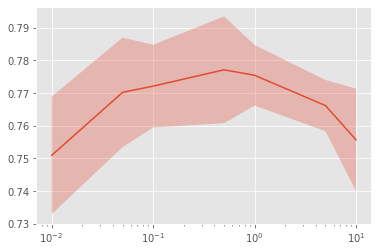

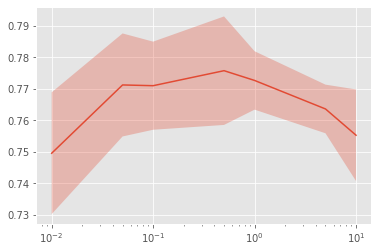

In [0]:
plot_scores(optimizer_zeros)
plot_scores(optimizer_mean)

In [0]:
roc_auc_score_zeros = roc_auc_score(y_test, optimizer_zeros.best_estimator_.predict_proba(X_test_zeros)[:, 1])
print (f'Best parameter for GridSearchCV with zero fillna: {optimizer_zeros.best_params_}')
print (f'roc_auc_score_zeros: {roc_auc_score_zeros} \n')

roc_auc_score_mean = roc_auc_score(y_test, optimizer_mean.best_estimator_.predict_proba(X_test_mean)[:, 1])
print (f'Best parameter for GridSearchCV with mean fillna: {optimizer_mean.best_params_}')
print (f'roc_auc_score_mean: {roc_auc_score_mean}')

Best parameter for GridSearchCV with zero fillna: {'C': 0.5}
roc_auc_score_zeros: 0.8774455516357711 

Best parameter for GridSearchCV with mean fillna: {'C': 0.5}
roc_auc_score_mean: 0.8768008701344179


## Numerical features scaling.

Let's takу a look at the data and see what we can do to achieve better scores:

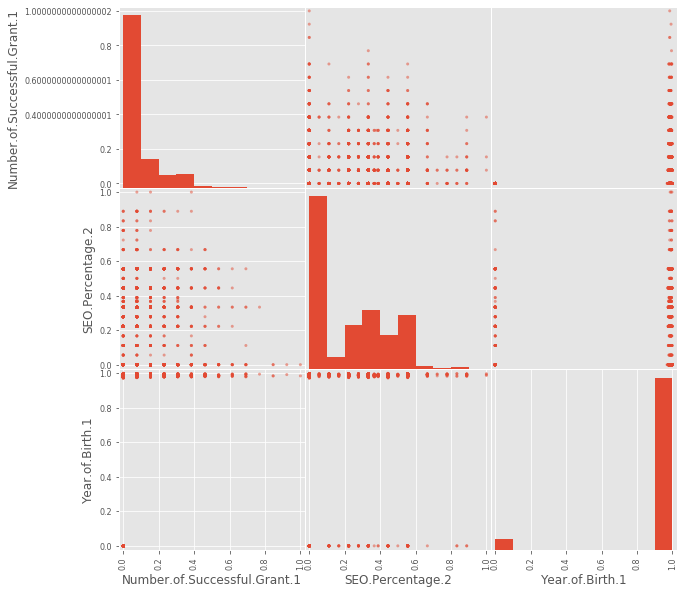

In [0]:
from pandas.plotting import scatter_matrix

data_numeric = pd.DataFrame(X_train_real_zeros, columns=numeric_cols)
list_cols = ['Number.of.Successful.Grant.1', 'SEO.Percentage.2', 'Year.of.Birth.1']
scatter_matrix(data_numeric[list_cols], alpha=0.5, figsize=(10, 10))
plt.show()

As we can see, the features have different scales. With regularization, using them as they are will cost us accuracy. In this case, it's always recommended to do feature scaling to make them less different from each other. 

Even if the resulting quality of the model will decrease on the test, it will increase its 'interpretability' because new weights are characterizing the importance of feature for resulting classification.

Scaling is done as follows:

$$ x^{scaled}_{id} = \dfrac{x_{id} - \mu_d}{\sigma_d}, \quad \mu_d = \frac{1}{N} \sum_{i=1}^l x_{id}, \quad \sigma_d = \sqrt{\frac{1}{N-1} \sum_{i=1}^l (x_{id} - \mu_d)^2} $$

## Task 1.5. Numerical feature scaling.

1. Scale features in X_train_real_zeros и X_test_real_zeros datasets, using

        StandardScaler
   
   class and methods

        StandardScaler.fit_transform(...)
        StandardScaler.transform(...)
        
2. Call new datasets X_train_real_scaled and X_test_real_scaled.

In [0]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_real_scaled = scaler.fit_transform(X_train_real_zeros, y_train)
X_test_real_scaled = scaler.fit_transform(X_test_real_zeros)

## Comparison of feature spaces.

Let's see, what we got now.

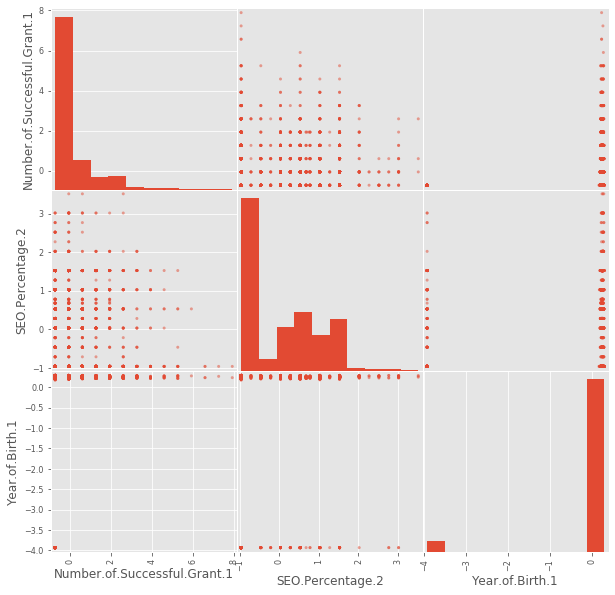

In [0]:
data_numeric_scaled = pd.DataFrame(X_train_real_scaled, columns=numeric_cols)
list_cols = ['Number.of.Successful.Grant.1', 'SEO.Percentage.2', 'Year.of.Birth.1']
scatter_matrix(data_numeric_scaled[list_cols], alpha=0.5, figsize=(10, 10))
plt.show()

As we see hists and graphs have stayed the same - we had not changed features space properties, but now all of our features seem to be in the pretty same range. It's better for the interpretation of results and regularization.

## Task 2. Classification accuracy comparison before and after feature scaling.
1. Train regression once more with new scaled features.
2. Check if you've found accuracy maximum.
3. Get ROC AUC values, compare them to previous results.

In [0]:
%%time
X_train_scaled = np.hstack((X_train_real_scaled, X_train_cat_oh))
X_test_scaled = np.hstack((X_test_real_scaled, X_test_cat_oh))

optimizer_zeros.fit(X_train_scaled, y_train)

roc_auc_score_scaled = roc_auc_score(y_test, optimizer_zeros.best_estimator_.predict_proba(X_test_scaled)[:, 1])
print (f'Best parameter for GridSearchCV with scaled num parameters: {optimizer_mean.best_params_}')
print (f'roc_auc_score_mean: {roc_auc_score_scaled}')

Best parameter for GridSearchCV with scaled num parameters: {'C': 0.5}
roc_auc_score_mean: 0.8843588636282079
CPU times: user 5.22 s, sys: 2.09 s, total: 7.31 s
Wall time: 4.89 s


## Handling Imbalanced Classes.


Classification algorithms can be very sensitive to imbalanced classes. Let's look at the following example, where two datasets are made from 2 normal distributions. Let's put into training data 20 objects sampled from the first data and 10 from the second one. After it, we will train linear regression and plot the data to analyze it.

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


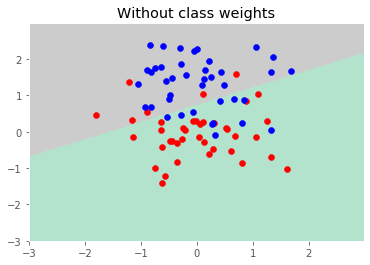

AUC: 0.866667


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


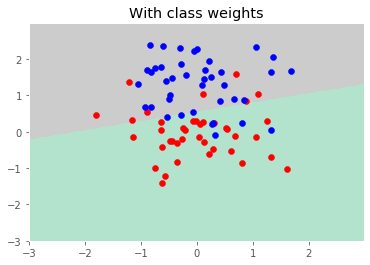

AUC: 0.895000


In [0]:
np.random.seed(0)

data_0 = np.random.multivariate_normal([0,0], [[0.5,0],[0,0.5]], size=40)
data_1 = np.random.multivariate_normal([0,1], [[0.5,0],[0,0.5]], size=40)

example_data_train = np.vstack([data_0[:20,:], data_1[:10,:]])
example_labels_train = np.concatenate([np.zeros((20)), np.ones((10))])

example_data_test = np.vstack([data_0[20:,:], data_1[10:,:]])
example_labels_test = np.concatenate([np.zeros((20)), np.ones((30))])

xx, yy = np.meshgrid(np.arange(-3, 3, 0.02), np.arange(-3, 3, 0.02))

optimizer = GridSearchCV(LogisticRegression(solver='liblinear'), param_grid, cv=cv, n_jobs=-1, iid=True)
optimizer.fit(example_data_train, example_labels_train)

Z = optimizer.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Pastel2)
plt.scatter(data_0[:,0], data_0[:,1], color='red')
plt.scatter(data_1[:,0], data_1[:,1], color='blue')

auc_wo_class_weights = roc_auc_score(example_labels_test, optimizer.predict_proba(example_data_test)[:,1])
plt.title('Without class weights')
plt.show()
print('AUC: %f'%auc_wo_class_weights)

optimizer = GridSearchCV(LogisticRegression(solver='liblinear', class_weight='balanced'), param_grid, cv=cv, n_jobs=-1, iid=True)
optimizer.fit(example_data_train, example_labels_train)
Z = optimizer.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Pastel2)
plt.scatter(data_0[:,0], data_0[:,1], color='red')
plt.scatter(data_1[:,0], data_1[:,1], color='blue')
auc_w_class_weights = roc_auc_score(example_labels_test, optimizer.predict_proba(example_data_test)[:,1])
plt.title('With class weights')
plt.show()
print('AUC: %f'%auc_w_class_weights)

In the second case, classification founds a dividing surface that is closer to true (less overfits). That's why you should always think about class balance in train data.

Let's see if classes are balanced in our train dataset:

In [0]:
print(np.sum(y_train==0))
print(np.sum(y_train==1))

2316
1884


As we can see, no.

You can make it right various ways, but in this task, we will look at two of them:
- Giving bigger weights for minority class on the train. 
- Oversample minority class to be equal to the majority class.

## Task 3. Class balancing.
1. Train logistic regression, using weights (class_weight='balanced' param for regression) on scaled features, you calculated in previous task.
2. Calculate ROC AUC.
3. Balance dataset with minority class oversampling. For getting indexes of objects to add, use this methods:
        np.random.seed(0)
        indices_to_add = np.random.randint(...)
        X_train_to_add = X_train[y_train.as_matrix() == 1,:][indices_to_add,:]
After this add addditional objects in the begginig or end of train data. Fill labels appropriately.
4.  Calculate ROC AUC, compare it to previous results.

In [0]:
%%time
param_grid = {'C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10]}
cv = 3
estimator = LogisticRegression(solver='liblinear', class_weight='balanced')

optimizer = GridSearchCV(estimator, param_grid, cv=cv, iid=True)
optimizer.fit(X_train_scaled, y_train)


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


CPU times: user 5.22 s, sys: 1.99 s, total: 7.21 s
Wall time: 4.8 s


In [0]:
roc_auc_score_bal1 = roc_auc_score(y_test, optimizer.best_estimator_.predict_proba(X_test_scaled)[:, 1])
print (f'Best parameter for GridSearchCV with balanced weights: {optimizer_mean.best_params_}')
print (f'roc_auc_score: {roc_auc_score_bal1}')

Best parameter for GridSearchCV with balanced weights: {'C': 0.5}
roc_auc_score: 0.8866925859152559


In [0]:
num_of_indices = np.sum(y_train==0) - np.sum(y_train==1)
print(np.sum(y_train==0))
print(np.sum(y_train==1))

answers = y_train[y_train].index.values
indexes_of_first_class = np.where(answers)[0]

2316
1884


/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:1146: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


In [0]:
np.random.seed(0)
num_of_indices = np.sum(y_train==0) - np.sum(y_train==1)
indices_to_add = np.random.choice(list(indexes_of_first_class), size=num_of_indices)
X_train_to_add = X_train_scaled.take(indices_to_add, axis=0)
y_train_to_add = y_train.take(indices_to_add)

print(np.sum(y_train_to_add==0))
print(np.sum(y_train_to_add==1))

print (f'/nY train to add: {y_train_to_add.shape}')
print (f'Y train: {y_train.shape} \n')

print (f'X train to add: {X_train_to_add.shape}')
print (f'X train: {X_train_scaled.shape}')



0
432
/nY train to add: (432,)
Y train: (4200,) 

X train to add: (432, 5606)
X train: (4200, 5606)


In [0]:
#new X, y train
X_train_balanced = np.vstack((X_train_scaled, X_train_to_add))
y_train_balanced = np.append(y_train, y_train_to_add)

print (X_train_balanced.shape, X_train_scaled.shape)
print (y_train_balanced.shape, y_train.shape)

(4632, 5606) (4200, 5606)
(4632,) (4200,)


Let's look at classes now

In [0]:
print(np.sum(y_train_balanced==0))
print(np.sum(y_train_balanced==1))

2316
2316


In [0]:
%%time
estimator = LogisticRegression(solver='liblinear',)
optimizer = GridSearchCV(estimator, param_grid, cv=cv)
optimizer.fit(X_train_balanced, y_train_balanced)
print(optimizer)

GridSearchCV(cv=3, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='liblinear',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)
CPU times: user 5.65 s, sys: 2.05 s, total: 7.7 s
Wall time: 5.24 s


In [0]:
roc_auc_score_bal2 = roc_auc_score(y_test, optimizer.best_estimator_.predict_proba(X_test_scaled)[:, 1])
print (f'Best parameter for GridSearchCV with balanced weights: {optimizer_mean.best_params_}')
print (f'roc_auc_score: {roc_auc_score_bal2}')

Best parameter for GridSearchCV with balanced weights: {'C': 0.5}
roc_auc_score: 0.8833974096425049


## Data stratification.

Let's look again at our previous example with normal distributions:

In [0]:
print('AUC ROC for classifier without weighted classes', auc_wo_class_weights)
print('AUC ROC for classifier with weighted classes: ', auc_w_class_weights)

AUC ROC for classifier without weighted classes 0.8666666666666667
AUC ROC for classifier with weighted classes:  0.895


Is the accuracy of the algorithm real, considering the fact, that testing data is imbalanced as training data was?
We already know that the logistic regression algorithm is sensitive to class balancing. The test metric would have much more sense if the classes would be separated equally. Let's reformat data and recalculate scores:

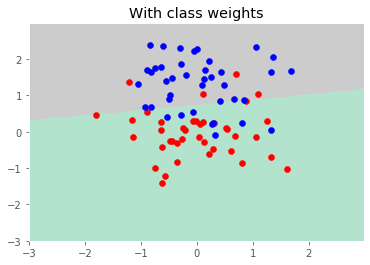

AUC ROC for stratified samples:  0.9125


In [0]:
example_data_train = np.vstack([data_0[:20,:], data_1[:20,:]])
example_labels_train = np.concatenate([np.zeros((20)), np.ones((20))])
example_data_test = np.vstack([data_0[20:,:], data_1[20:,:]])
example_labels_test = np.concatenate([np.zeros((20)), np.ones((20))])

optimizer = GridSearchCV(LogisticRegression(class_weight='balanced'), param_grid, cv=cv, n_jobs=-1)
optimizer.fit(example_data_train, example_labels_train)
Z = optimizer.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Pastel2)
plt.scatter(data_0[:,0], data_0[:,1], color='red')
plt.scatter(data_1[:,0], data_1[:,1], color='blue')
auc_stratified = roc_auc_score(example_labels_test, optimizer.predict_proba(example_data_test)[:,1])
plt.title('With class weights')
plt.show()
print('AUC ROC for stratified samples: ', auc_stratified)

As we see, the classifier answer stayed pretty same, but AUC ROC increased. Depending oа balance of classes final metric on the test could increase or decrease, but we can trust it more because it was built in accordance with the classifier specific.

## Task 4. Data stratification.

1. As it was in task 1, form datasets X_real_zeros and X_cat_oh but now with adding in function
        train_test_split(...)
   additional parm 
       stratify=y
   Also, don't forget about random_state=0.
2. Do the feature scaling, train regression, considering balance, using weights. Check the accuracy max.
3. Calculate AUC ROC on the test.

In [0]:
from sklearn.model_selection import train_test_split

(X_train_real_zeros, 
 X_test_real_zeros, 
 y_train, y_test) = train_test_split(X_real_zeros, y, 
                                     test_size=0.3, 
                                     random_state=0,
                                     stratify=y)

(X_train_cat_oh,
 X_test_cat_oh) = train_test_split(X_cat_oh, 
                                   test_size=0.3, 
                                   random_state=0,
                                   stratify=y)

In [0]:
scaler = StandardScaler()

scaler.fit(X_train_real_zeros, y_train)
X_train_real_scaled = scaler.transform(X_train_real_zeros)

scaler.fit(X_test_real_zeros, y_test)
X_test_real_scaled = scaler.transform(X_test_real_zeros)

#stacking numerical and categorical features
X_train_scaled = np.hstack( (X_train_real_scaled, X_train_cat_oh) )
X_test_scaled = np.hstack( (X_test_real_scaled, X_test_cat_oh) )

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


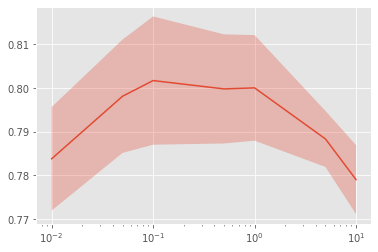

Best parameter for GridSearchCV with balanced weights: {'C': 0.5}
roc_auc_score: 0.8794071768692251
AUC: 0.924437


In [0]:
optimizer = GridSearchCV(LogisticRegression(solver='liblinear', class_weight='balanced'), param_grid, cv=cv, n_jobs=-1)
optimizer.fit(X_train_scaled, y_train)
plot_scores(optimizer)

roc_auc_score_strat = roc_auc_score(y_test, optimizer.best_estimator_.predict_proba(X_test_scaled)[:, 1])
print (f'Best parameter for GridSearchCV with balanced weights: {optimizer_mean.best_params_}')
print (f'roc_auc_score: {roc_auc_score_strat}')

auc_w_class_weights = roc_auc_score(y_train, optimizer.predict_proba(X_train_scaled)[:,1])
print('AUC: %f'%auc_w_class_weights)

We looked through basic stages of data preprocessing for linear classifiers. 


*  Filling missed values
*  Encoding categorial features
*  Stratification
*  Class balancing
*  Scaling

These stages are recommended every time you're working with linear regression models. Many of them are useful for other models too.

## Features transformation

There are many ways to transform features to produce more complex separating hyperplanes. One of the base methods called 'polynomial features'. The idea behind it is to include into dataset all polynoms of first degree that you can get by combining them. For examle: 

$$ \phi(x_i) = [x_{i,1}^2, ..., x_{i,D}^2, x_{i,1}x_{i,2}, ..., x_{i,D} x_{i,D-1}, x_{i,1}, ..., x_{i,D}, 1] $$

Let's look into it on our normal distributions example (again):

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


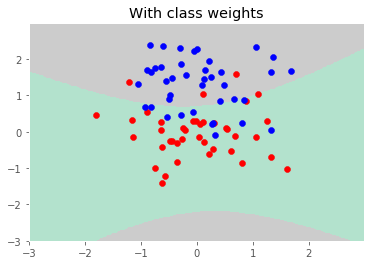

In [0]:
from sklearn.preprocessing import PolynomialFeatures

transform = PolynomialFeatures(2)

example_data_train_poly = transform.fit_transform(example_data_train)
example_data_test_poly = transform.transform(example_data_test)

optimizer = GridSearchCV(LogisticRegression(solver='liblinear', class_weight='balanced', fit_intercept=False), param_grid, cv=cv, n_jobs=-1, iid=True)
optimizer.fit(example_data_train_poly, example_labels_train)
Z = optimizer.predict(transform.transform(np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Pastel2)
plt.scatter(data_0[:,0], data_0[:,1], color='red')
plt.scatter(data_1[:,0], data_1[:,1], color='blue')
plt.title('With class weights')
plt.show()

As we can see, this method allows us to create more complex separating hyperplanes, which can estimate our data more precise and describe more complex functions. The number of features in a new model:

In [0]:
print(example_data_train_poly.shape)

(40, 6)


But you need to remember, that this method can lead to overfitting due to the fast growth of a number of features with the growth of polynomial degree.
Let's check, for example, p=11.

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


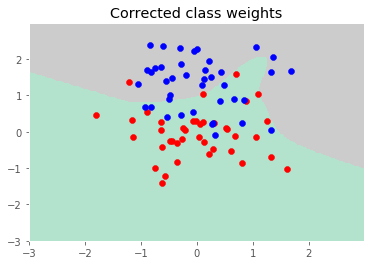

In [0]:
transform = PolynomialFeatures(11)
example_data_train_poly = transform.fit_transform(example_data_train)
example_data_test_poly = transform.transform(example_data_test)
optimizer = GridSearchCV(LogisticRegression(solver='liblinear', class_weight='balanced', fit_intercept=False), param_grid, cv=cv, n_jobs=-1, iid=True)
optimizer.fit(example_data_train_poly, example_labels_train)
Z = optimizer.predict(transform.transform(np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Pastel2)
plt.scatter(data_0[:,0], data_0[:,1], color='red')
plt.scatter(data_1[:,0], data_1[:,1], color='blue')
plt.title('Corrected class weights')
plt.show()

The number of features in a new model:

In [0]:
print(example_data_train_poly.shape)

(40, 78)


## Task 5. Numerical features transformations.

1. Transform numeric features of our model with a polynomial with degree 2.
2. Train logistic regression on a new dataset with optimal C params. In transformed features already exists a column filled with ones, so you need to pass additional param:

`fit_intercept=False`

      when training it. Use stratified datasets with weight-balanced classes.
      You need to do scaling on transformed features. 
3. Calculate AUC ROC on test data and compare it to the previous results.

In [0]:
transform = PolynomialFeatures(3)

data_train_poly = transform.fit_transform(X_train_real_zeros)
data_test_poly = transform.transform(X_test_real_zeros)

encoder = StandardScaler()

data_train_poly_scaled = scaler.fit_transform(data_train_poly, y_train)
data_test_poly_scaled = scaler.fit_transform(data_test_poly)

#stacking numerical and categorical features
data_train_poly_full = np.hstack( (data_train_poly_scaled, X_train_cat_oh) )
data_test_poly_full = np.hstack( (data_test_poly_scaled, X_test_cat_oh) )

In [0]:
param_grid = {'C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10]}
cv = 3
estimator = LogisticRegression(solver='liblinear', class_weight='balanced', fit_intercept=False)

optimizer = GridSearchCV(estimator, param_grid, cv=cv, iid=True)
optimizer.fit(data_train_poly_full, y_train)


roc_auc_score_poly = roc_auc_score(y_test, optimizer.best_estimator_.predict_proba(data_test_poly_full)[:, 1])
print (f'Best parameter for GridSearchCV with balanced weights: {optimizer.best_params_}')
print (f'roc_auc_score: {roc_auc_score_poly}')

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


Best parameter for GridSearchCV with balanced weights: {'C': 0.1}
roc_auc_score: 0.8908424512013694


## Lasso Regression.
You can also apply L1 regularization to logistic regression. L1 regularization will help to 'select' the features. Apply L1 regularization to data features and interpret the results. To use L1 regularization, you just need to pass "penalty='l1'" param to class initialization.

## Task 6. Feature selection with Lasso regression.
1. Train Lasso regression on stratified data, using weight balanced classes.
2. Calculate AUC ROC, compare it to the previous results.
3. Find features, that had zero weights in the model.

In [0]:
encoder = StandardScaler()

data_train_lasso_scaled = encoder.fit_transform(X_train_real_zeros)
data_test_lasso_scaled = encoder.fit_transform(X_test_real_zeros)

#stacking numerical and categorical features
data_train_lasso_full = np.hstack( (data_train_lasso_scaled, X_train_cat_oh) )
data_test_lasso_full = np.hstack( (data_test_lasso_scaled, X_test_cat_oh) )

#GridSearchCV parameters
param_grid = {'C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10]}
cv = 3
estimator = LogisticRegression(solver='liblinear', class_weight='balanced', fit_intercept=False, penalty='l1')

optimizer = GridSearchCV(estimator, param_grid, cv=cv, iid=True)
optimizer.fit(data_train_lasso_full, y_train)

roc_auc_score_lasso = roc_auc_score(y_test, optimizer.best_estimator_.predict_proba(data_test_lasso_full)[:, 1])
print ('Best parameter for GridSearchCV with balanced weights', optimizer.best_params_)
print ('roc_auc_score', roc_auc_score_lasso)

print (optimizer.best_estimator_.coef_.ravel())
print (X_train_real_zeros.shape[1])
zero_coefs = [index for index, value in enumerate(optimizer.best_estimator_.coef_[0][:13]) if value == 0]
print (zero_coefs)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


Best parameter for GridSearchCV with balanced weights {'C': 1}
roc_auc_score 0.8766655969031589
[ 0.00899071  0.03989431 -0.08870299 ...  0.67698004  0.
  0.34710606]
13
[4, 6, 7]
